In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import layers, models, regularizers
import kagglehub
import os
import pathlib
from sklearn.model_selection import train_test_split

c:\Users\luizc\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#CARREGANDO E PREPARANDO O DATASET
path = kagglehub.dataset_download("rakibuleceruet/drowsiness-prediction-dataset")
data_dir = pathlib.Path(os.path.join(path, '0 FaceImages'))

active_paths = list(data_dir.glob('Active Subjects/*.jpg'))
active_labels = [0] * len(active_paths) # 0 para 'alerta'
fatigue_paths = list(data_dir.glob('Fatigue Subjects/*.jpg'))
fatigue_labels = [1] * len(fatigue_paths) # 1 para 'fadiga'

all_image_paths = [str(p) for p in (active_paths + fatigue_paths)]
all_labels = active_labels + fatigue_labels

train_paths, val_paths, train_labels, val_labels = train_test_split(
    all_image_paths, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)

train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

def load_and_preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMAGE_SIZE)
    return image, label

train_dataset = train_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE).cache().shuffle(len(train_paths)).batch(BATCH_SIZE).prefetch(AUTOTUNE)
validation_dataset = val_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)


In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
], name="data_augmentation")

# CARREGA O MODELO BASE MOBILENETV2 PRÉ-TREINADO
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False # CONGELANDO OS PESOS DO MODELO

# CAMADAS DE CLASSIFICAÇÃO 
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x) 
x = tf.keras.layers.Dropout(0.4)(x) #mudança do dropout

outputs = tf.keras.layers.Dense(1, 
                                activation='sigmoid',
                                kernel_regularizer=regularizers.l2(0.001) #adicionando regularização L2
                                )(x)

model_tl = tf.keras.Model(inputs, outputs) 

otimizador_teste = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9) #novo otimizador para teste

#novas metricas
METRICAS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model_tl.compile(
    optimizer = otimizador_teste, # Usando o novo otimizador
    loss = 'binary_crossentropy',
    metrics = METRICAS 
)

#Iniciando o treinamento do modelo de Transfer Learning
history_tl = model_tl.fit(
    train_dataset,
    epochs=15,
    validation_data=validation_dataset
)

print("\n--- Avaliação Final do Modelo de Transfer Learning ---")
val_loss_tl, val_acc_tl, val_precision_tl, val_recall_tl = model_tl.evaluate(validation_dataset, verbose=2)

print(f"Acurácia final no conjunto de validação: {val_acc_tl * 100:.2f}%")
print(f"Precisão final no conjunto de validação: {val_precision_tl * 100:.2f}%")
print(f"Recall final no conjunto de validação: {val_recall_tl * 100:.2f}%")

Epoch 1/15
228/228 ━━━━━━━━━━━━━━━━━━━━ 56s 231ms/step - accuracy: 0.6979 - loss: 0.5702 - precision: 0.6930 - recall: 0.7105 - val_accuracy: 0.7747 - val_loss: 0.4766 - val_precision: 0.7668 - val_recall: 0.7895
Epoch 2/15
228/228 ━━━━━━━━━━━━━━━━━━━━ 50s 220ms/step - accuracy: 0.7670 - loss: 0.4673 - precision: 0.7563 - recall: 0.7878 - val_accuracy: 0.7845 - val_loss: 0.4503 - val_precision: 0.7695 - val_recall: 0.8125
Epoch 3/15
228/228 ━━━━━━━━━━━━━━━━━━━━ 54s 238ms/step - accuracy: 0.7782 - loss: 0.4436 - precision: 0.7672 - recall: 0.7988 - val_accuracy: 0.7845 - val_loss: 0.4358 - val_precision: 0.7740 - val_recall: 0.8037
Epoch 4/15
228/228 ━━━━━━━━━━━━━━━━━━━━ 52s 228ms/step - accuracy: 0.7878 - loss: 0.4347 - precision: 0.7768 - recall: 0.8078 - val_accuracy: 0.7971 - val_loss: 0.4287 - val_precision: 0.7794 - val_recall: 0.8289
Epoch 5/15
228/228 ━━━━━━━━━━━━━━━━━━━━ 50s 219ms/step - accuracy: 0.7906 - loss: 0.4280 - precision: 0.7794 - recall: 0.8106 - val_accuracy: 0.8043

In [8]:
import pickle

MODELS_DIR = "saved_models"
HISTORIES_DIR = "historicos"
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(HISTORIES_DIR, exist_ok=True)   

model_tl_path = os.path.join(MODELS_DIR, 'modelo_transfer_learningv2.keras')
model_tl.save(model_tl_path)

loaded_model = tf.keras.models.load_model(model_tl_path)

#EXTRATOR DE CARACTERÍSTICAS

feature_extractor = tf.keras.Model(
    inputs=loaded_model.input,
    outputs=loaded_model.get_layer('global_average_pooling2d_1').output
    )

history_tl_path = os.path.join(HISTORIES_DIR, 'history_transfer_learningv2.pkl')

with open(history_tl_path, 'wb') as file:
    pickle.dump(history_tl.history, file)
    
print("modelo e histórico de treinamento salvos")

feature_extractor.summary()

modelo e histórico de treinamento salvos


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

57/57 - 9s - 163ms/step - accuracy: 0.8202 - loss: 0.4037 - precision: 0.8518 - recall: 0.7752

Acurácia de validação final: 0.8201754093170166


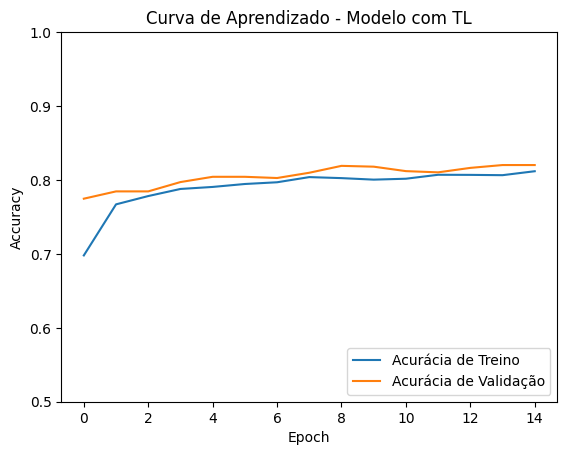

In [11]:
import matplotlib.pyplot as plt
import numpy as np


plt.title("Curva de Aprendizado - Modelo com TL"  )
plt.plot(history_tl.history['accuracy'], label='Acurácia de Treino')
plt.plot(history_tl.history['val_accuracy'], label='Acurácia de Validação')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

val_loss_tl, val_acc_tl, val_precision_tl, val_recall_tl = model_tl.evaluate(validation_dataset, verbose=2)

print("\nAcurácia de validação final:", val_acc_tl)